In [3]:
import numpy as np
import matplotlib.pyplot as plt

def read_currents_file(filepath):
    # Read the file content
    with open(filepath, 'r') as file:
        # Read the first line to get current names
        header_line = file.readline().strip()
        
        # Split the header first by semicolons, then by commas
        current_groups = header_line.split(';')
        current_names = []
        for group in current_groups:
            currents = [name.strip() for name in group.split(',')]
            current_names.extend(currents)
            
        # Initialize dictionary with empty lists for each current
        data_dict = {name: [] for name in current_names}
        
        # Read the rest of the lines
        for line in file:
            if not line.strip():  # Skip empty lines
                continue
            
            # Split values by semicolon first, then comma
            value_groups = line.strip().split(';')
            values = []
            for group in value_groups:
                group_values = [float(val.strip()) for val in group.split(',') if val.strip()]
                values.extend(group_values)
            
            # Add each value to corresponding current's list
            for name, value in zip(current_names, values):
                data_dict[name].append(value)
    
    # Convert lists to numpy arrays for easier manipulation
    for name in data_dict:
        data_dict[name] = np.array(data_dict[name])
    
    return data_dict

# Example usage:
filepath = 'currents_ovvr_APD_step_3.csv'
currents_data = read_currents_file(filepath)

# Print information about the data
print("Available currents:")
for current_name, values in currents_data.items():
    print(f"{current_name}: {len(values)} time points, range: [{min(values):.3f}, {max(values):.3f}]")

Available currents:
voltage: 5000 time points, range: [-87.865, 34.886]
INa: 5000 time points, range: [-181.166, -0.001]
Ito: 5000 time points, range: [-0.000, 0.383]
ICaL: 5000 time points, range: [-4.063, -0.000]
IKr: 5000 time points, range: [-0.001, 0.851]
IKs: 5000 time points, range: [-0.001, 0.103]
IK1: 5000 time points, range: [-0.034, 0.826]
INaCa: 5000 time points, range: [-0.373, 0.012]
INaK: 5000 time points, range: [0.097, 0.200]
INab: 5000 time points, range: [-0.017, -0.002]
ICab: 5000 time points, range: [-0.020, -0.001]
IKb: 5000 time points, range: [-0.000, 0.277]
IpCa: 5000 time points, range: [0.000, 0.000]
INalate: 5000 time points, range: [-0.282, -0.000]
NA: 15000 time points, range: [0.000, 0.000]


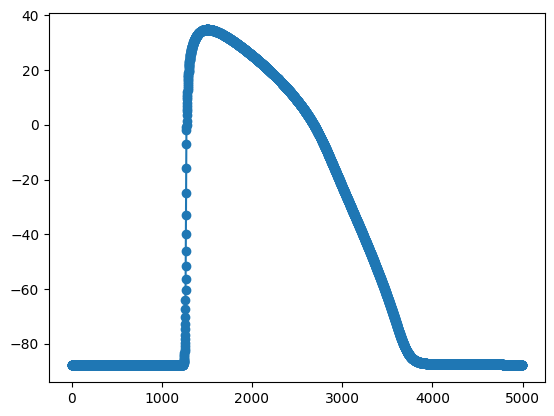

In [4]:
# get the time step range where voltage is bigger than -
mask =  -100< currents_data['voltage']
plt.plot(currents_data['voltage'][mask],'-o')

In [28]:
matrix = np.zeros((len(currents_data['voltage'][mask]),len(currents_data)-2))  # Exclude voltage and NA from currents
I_total = np.zeros(len(currents_data['voltage'][mask]))

In [29]:
# assign currents to matrix columns
for i, (current_name, values) in enumerate(currents_data.items()):
    if current_name not in ['voltage', 'NA']:
        matrix[:, i - (1 if 'voltage' in currents_data else 0) - (1 if 'NA' in currents_data else 0)] = values[mask]

In [30]:

# assign currents_sum to I_total columns
for t in range(len(currents_data['voltage'][mask])):
    I_total[t] = sum(matrix[t,:])

In [31]:
# check if I_total = matrix*(1,1,1,1...)^T
# mu is a vector with length equal to the number of rows in the matrix
mu = np.ones(matrix.shape[1])
# transpose mu

# now we multiply the matrix by mu
I_check = matrix @ mu
print(np.allclose(I_check, I_total))  # This should print True if they are equal

True


In [53]:
U, S, V = np.linalg.svd(matrix)

In [54]:
#transposeV
Vt = V.T


In [55]:
S

array([3.23069372e+02, 4.05795024e+01, 2.40966629e+01, 1.24057354e+01,
       5.65439509e+00, 4.93858782e+00, 2.46305205e+00, 1.55280878e+00,
       9.12046238e-01, 5.05632665e-01, 3.46471524e-02, 6.31647922e-04,
       1.77981632e-04])

In [ ]:
V

array([[ 8.93358362e-04, -1.26374490e-02,  4.24236194e-03,
         1.76956889e-04,  1.52338840e-04, -9.13154493e-04,
         2.09110327e-03, -6.84812734e-05, -4.84101575e-05,
         1.16923596e-03,  1.32289916e-06, -2.87609477e-03,
        -9.99903291e-01],
       [-1.20796807e-01,  7.51759734e-01, -5.60469026e-01,
        -5.57157028e-02, -4.51682326e-02,  1.08841092e-01,
        -1.94227079e-01,  5.54939135e-03,  4.16454096e-03,
        -1.74466413e-01, -2.14875231e-04,  1.44103716e-01,
        -1.31285303e-02],
       [ 1.04189916e-01, -6.00272520e-01, -7.44924877e-01,
        -6.96611912e-02, -1.94631545e-01,  1.16121684e-01,
        -1.04653232e-01,  1.11041813e-02,  1.11190491e-02,
         4.89911422e-02, -1.48210992e-04,  6.37991980e-02,
         4.02477665e-03],
       [-1.89089451e-02,  8.40896831e-02,  2.06664788e-01,
         6.94583708e-02, -9.41467766e-01,  1.92931412e-01,
        -7.93866471e-02,  2.53804434e-02,  2.97545833e-02,
         6.13647205e-02, -1.33942689e

In [101]:
def projection_S(v):
    ps = [0] * len(S)
    for i in range(2,len(V)):
        ps += np.inner(v,V[i]) / np.inner(V[i],V[i]) * V[i]
    return ps
identifiability = {}
for i, (current_name, values) in enumerate(currents_data.items()):
    if current_name in ['voltage', 'NA']:
        continue
    v_I = [0]*len(S)
    v_I[i-2] = 1
    k = np.linalg.norm(v_I-projection_S(v_I))
    identifiability[current_name] = k

In [102]:
identifiability
# now we sort identifiability by its value
sorted_identifiability = dict(sorted(identifiability.items(), key=lambda item: item[1], reverse=True))
sorted_identifiability

{'INa': np.float64(0.9999894751006916),
 'ICaL': np.float64(0.7518659477604241),
 'IKr': np.float64(0.5604850813081879),
 'INaK': np.float64(0.1942383352214385),
 'IKb': np.float64(0.1744703311444147),
 'INalate': np.float64(0.1441324148725148),
 'Ito': np.float64(0.12080011064809532),
 'INaCa': np.float64(0.10884492271495684),
 'IKs': np.float64(0.055715983826319426),
 'IK1': np.float64(0.0451684894777352),
 'INab': np.float64(0.005549813870315541),
 'ICab': np.float64(0.004164822317222974),
 'IpCa': np.float64(0.0002148793028104024)}